In [32]:
import numpy as np
from sklearn import gaussian_process as gp
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import solve_ivp
np.random.seed(15)

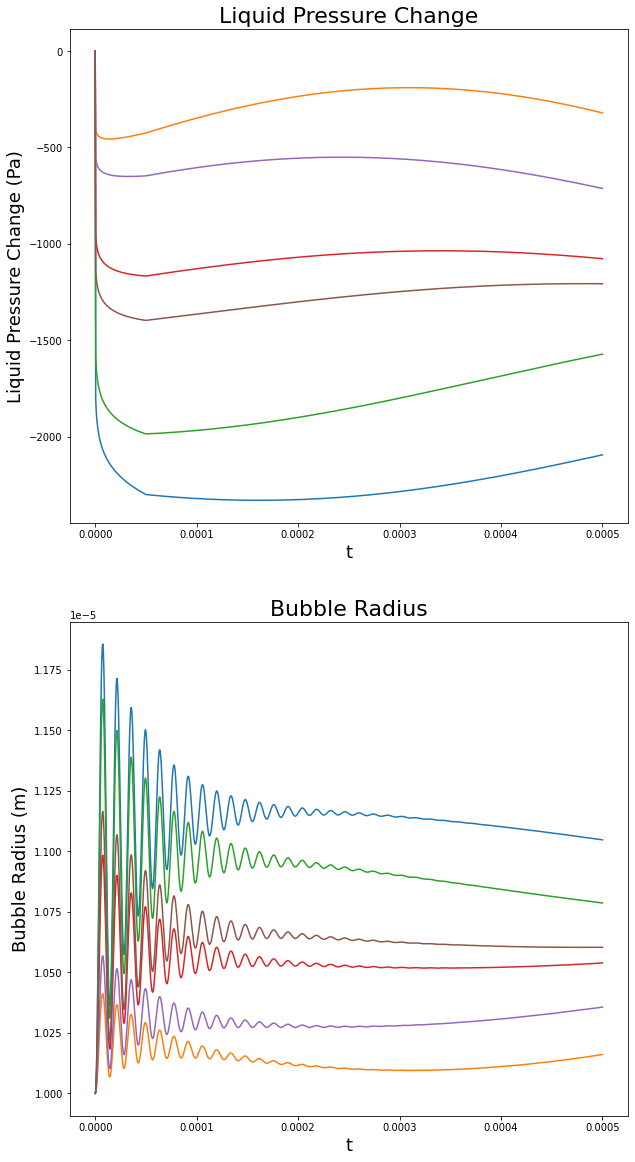

In [40]:
def generate_del_p(Par):
    np.random.seed(15)
    n=Par['n']
    length_scale = Par['length_scale']
    t_max = Par['t_max']
    res = Par['res']
    q = Par['q']
    T = Par['T']

    t=np.linspace(0,t_max,res)[:,None]
    K=gp.kernels.RBF(length_scale=length_scale)
    K=K(t) #symmetric matrix
    L=np.linalg.cholesky(K + 1e-13*np.eye(res)) #Lower triangular form of K
    temp = np.random.normal(loc=0, scale=25, size=(res,n))
    del_p=np.dot(K,temp).T
    del_p = del_p - 1500

    index = int(q*T/t_max*res)

    t1 = t[:index,:]
    t2 = t[index:,:]
    s1 = (t1/(q*T))**0.05
    s2 = np.ones(np.shape(t2))
    ss = np.concatenate([s1,s2], axis=0)

    del_p = del_p * np.ravel(ss)
    
    return del_p

def ode_sol(t, y, c1, c2, c):
    r = y[0]
    v = y[1]
    return [v, -c1*v -c2*r + c(t)]

def generate_data():
    Par = {}
    Par['n']=10 #number of samples
    Par['length_scale'] = 0.8*5*10**-4 #GRF length_scale. To be changed while generating test datasets
    Par['t_max'] = 5*10**-4  #final timestep
    Par['res'] = 1000  #Resolution DO NOT CHANGE
    Par['q'] = 0.1   #q in paper
    Par['T'] = 5*10**-4 #T in paper

    del_p = generate_del_p(Par)
    c_arr = -100*del_p #High Resolution data R \in 1000

    c1= 40000
    c2 = 2*10**11
    R0 = 10**-5

    t = np.linspace(0, Par['t_max'], 1000)

    R_ls = []
    for sample in range(del_p.shape[0]):
        c = interp1d(np.ravel(t), c_arr[sample], kind='cubic')
        sol0 = solve_ivp(fun = ode_sol, t_span = [t[0], t[-1]], y0 = [0, 10**-5], t_eval = t, args = (c1, c2, c))
        temp = np.reshape(sol0.y[0], (1,-1)) + R0
        R_ls.append(temp)

    R = np.concatenate(R_ls, axis=0)

    #np.savez('data_GRF_l_0.2', t=t, del_p=del_p, R=R)

    fig, (ax1,ax2) = plt.subplots(2,1,figsize=(10,20))
    for i in range(6):
        ax1.plot(t, del_p[i])
        ax1.set_title('Liquid Pressure Change', fontsize=22)
        ax1.set_xlabel('t', fontsize=18)
        ax1.set_ylabel('Liquid Pressure Change (Pa)', fontsize=18)
        ax1.ticklabel_format(style='sci')

        ax2.plot(t, R[i])
        ax2.set_title('Bubble Radius', fontsize=22)
        ax2.set_xlabel('t', fontsize=18)
        ax2.set_ylabel('Bubble Radius (m)', fontsize=18)
        ax2.ticklabel_format(style='sci')

    plt.show()
    
generate_data()

In [6]:
print(c_arr.shape)
print(t.shape)

(10, 1000)
(1000,)


In [29]:
t = np.load('0.1/res_1000.npz')['t']
tn = np.random.uniform(0,5*10**-4, 200)
#tn = np.linspace(0,5*10**-4, 100)
c_arr = np.load('0.1/res_1000.npz')['R']
c = interp1d(np.ravel(t), c_arr, kind='cubic')

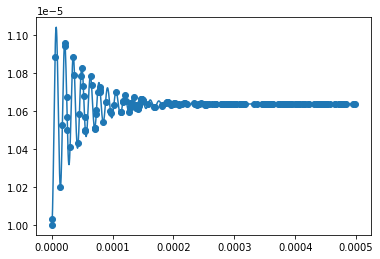

In [30]:

for i in range(1):
    plt.plot(t, c(t)[i])
    plt.scatter(tn, c(tn)[i])
plt.show()

In [31]:
c(t).shape

(1500, 1000)